## Project: VK network analysis

### German Sokolov

*******

### 1. Network summary.

In [692]:
import requests
from itertools import combinations
import vk
import time
import numpy as np
import scipy as sp
from scipy import spatial
import networkx as nx
import igraph
from community import modularity, best_partition
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('ggplot')
% matplotlib inline

One can use vkontakte API to get all available information about friends, including important attributes - sex, age, city etc.

In [1189]:
# use vk.API to download network:
my_uid = '14687743'
token = '4d2f4654c44fe6730bf7d9e16f93cdb0cdd64ac212049951341d39a950c9010672c30fe96e9a332dbc1cb'
session = vk.Session(access_token=token)
api = vk.API(session)

In [3]:
def user_info(uid):
    time.sleep(1) # this is necessary not to overload the connection 
    data_to_show = {}
    # the attributes of friends(nodes):
    data = api.users.get(user_id = uid, fields = 'sex, education, city')[0]
    # replace missing values with 'NA':
    if 'deactivated' in data.keys():
        data['city'] = 0
        data['university_name'] = 'NA'
    if 'university_name' not in data.keys() or data['university_name'] == '':
        data['university_name'] = 'NA'
    if data['city'] != 0:
        data['city'] = api.database.getCitiesById(city_ids = str(data['city']))[0]['name']
    else:
        data['city'] = 'NA'
    # create single attribute 'name' from 'first_name' and 'last_name':
    data_to_show['name'] = data['first_name'] + " " + data['last_name']
    data_to_show['sex'] = data['sex']
    data_to_show['city'] = data['city']
    data_to_show['university_name'] = data['university_name'].strip()
    return data_to_show 

In [ ]:
friends_ids = api.friends.get(user_id = my_uid)
friends_ids = [str(x) for x in friends_ids]
uids = ','.join(friends_ids)

# define common friends with each of your friends:
common = api.friends.getMutual(souce_id = my_uid, target_uids = uids)

Once information is collected, the corresponding undirected graph can be created. All nodes contain attributes.

In [8]:
# create undirected graph:
G = nx.Graph()
count = 0

# add nodes with their attributes and edges:
for i in friends_ids:
    if int(i) not in G.nodes():
        G.add_node(int(i), user_info(int(i)))
    for j in common[count]['common_friends']:
        if j not in G.nodes():
            G.add_node(j, user_info(j))
        if all([(int(i), j), (j, int(i))]) not in G.edges():
            G.add_edge(int(i), j)
    count += 1

There is no need to do these operations many times - the graph can be saved and then opened at any time. 

In [9]:
# write the graph and the next time just open it:
nx.write_gexf(G, "vk_network.gexf")

In [372]:
# open the graph and set appropriate layout for better visualization:
G = nx.read_gexf('vk_network.gexf')
coord = nx.spring_layout(G, k = 0.15)

General information:
 - number of nodes - 162
 - number of edges - 1046
 - diameter - 11
 - average clustering coeff - 0.59
 
Attributes of nodes:
 - name
 - sex
 - university
 - city

In [1197]:
print("Number of nodes -", len(G.nodes()))
print("Number of edges -", len(G.edges()))

Number of nodes - 162
Number of edges - 1046


In [348]:
print("Attributes of nodes:")
print(list(user_info(G.nodes()[0]).keys()))

Attributes of nodes:
['name', 'sex', 'university_name', 'city']


In [351]:
for cc in nx.connected_component_subgraphs(G):
    print("Diameter of connected component -", nx.diameter(cc))
    print("Average clustering coefficient - {:.2f}".format(nx.average_clustering(cc)), "\n")

Diameter of connected component - 11
Average clustering coefficient - 0.59 

Diameter of connected component - 1
Average clustering coefficient - 0.00 

Diameter of connected component - 0
Average clustering coefficient - 0.00 

Diameter of connected component - 0
Average clustering coefficient - 0.00 



Plot the graph with the best possible layout:

(-0.94999999999999996, 1.05, -1.0, 0.75)

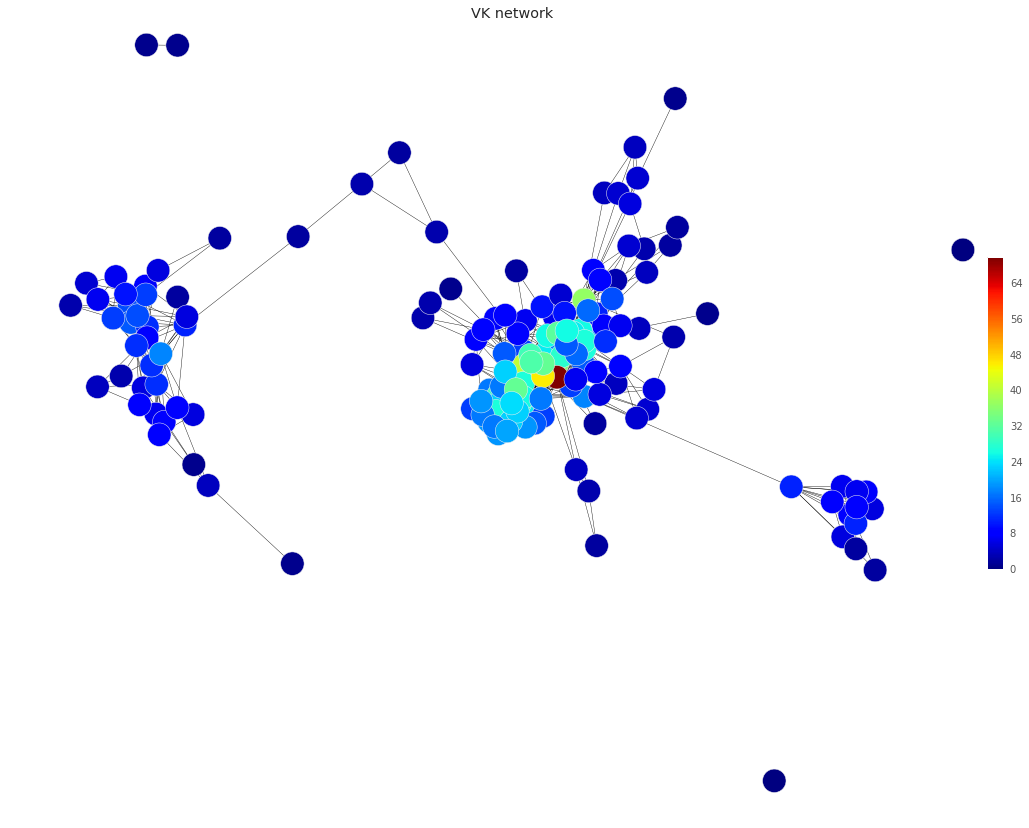

In [1394]:
plt.figure(figsize=(20,14))
k = nx.degree(G)
# set nodes' colors according to their degrees:
node_colors = list(k.values())

nodes = nx.draw_networkx_nodes(G, pos = coord, 
                               node_color=node_colors, 
                               node_size = 550, 
                               nodelist=list(k.keys()),                
                               with_labels = False,
                               cmap = 'jet')
edges = nx.draw_networkx_edges(G, pos = coord, width = .4)

# the borders can be then reduced to zoom in the graph:
plt.xlim([-.95, 1.05])
plt.ylim([-1., .75])
# add colorbar to see which nodes have the highest degrees:
plt.colorbar(nodes, shrink = .4, pad = .0005, aspect = 20)
plt.title('VK network')
plt.axis("off")

Several observations could be made by looking at the graph below:

- 1 giant connected component (CC)
- Several nodes have no connections at all or not included into CC (deleted accounts, random people)
- At least 3 distinct communities (hometown, universities) 
- 1 node is connected with almost 50% of graph nodes   

Let's look at nodes' degrees distribution.

In [1198]:
# function to create proper histogram in matplotlib:
def plot_hist(data, colormap, alpha, bins = 10, round_value = 1):
    cm = plt.cm.get_cmap(colormap)
    counts, bins, patches = plt.hist(data, alpha = alpha, color = 'Blue', bins = bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    plt.xticks(bins.round(round_value))
    col = bin_centers - min(bin_centers)
    col /= max(col)
    # use various colors for different bins:
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

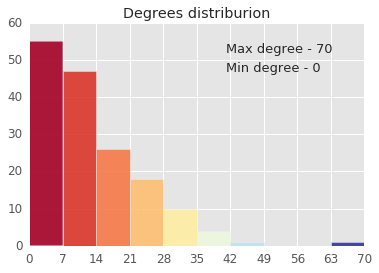

In [1375]:
plt.title("Degrees distriburion", y = 1.00)
plot_hist(data = list(k.values()), colormap = 'RdYlBu', alpha = 0.9, bins = 10, round_value=1)
plt.text(x = 41, y = 52, s = "Max degree - " + str(max(k.values())), fontsize = 13)
plt.text(x = 41, y = 47, s = "Min degree - " + str(min(k.values())), fontsize = 13)

The distribution is similar to power-law family, the vast majority of nodes have degree less than 14. Red node in the graph above has degree value 70. 

We are usually interested in connected component only, because other points in this case are:
 - deleted accounts
 - random friends, which I met only once

Finally, there is only 1 giant connected component:

In [1200]:
# take only giant connected component for the further analysis: 
Gc = max(nx.connected_component_subgraphs(G), key=len)
print("Number of nodes -", len(Gc.nodes()))
print("Number of edges -", len(Gc.edges()))

Number of nodes - 158
Number of edges - 1045


******

### 2. Structural analysis.

**Centrality measures:**

Let's start with degree centrality:

Top 1st node is Юра Погосян, degree centrality: 0.45 
Top 2nd node is Артём Семьянов, degree centrality: 0.29 
Top 3rd node is Игнат Усок, degree centrality: 0.26 


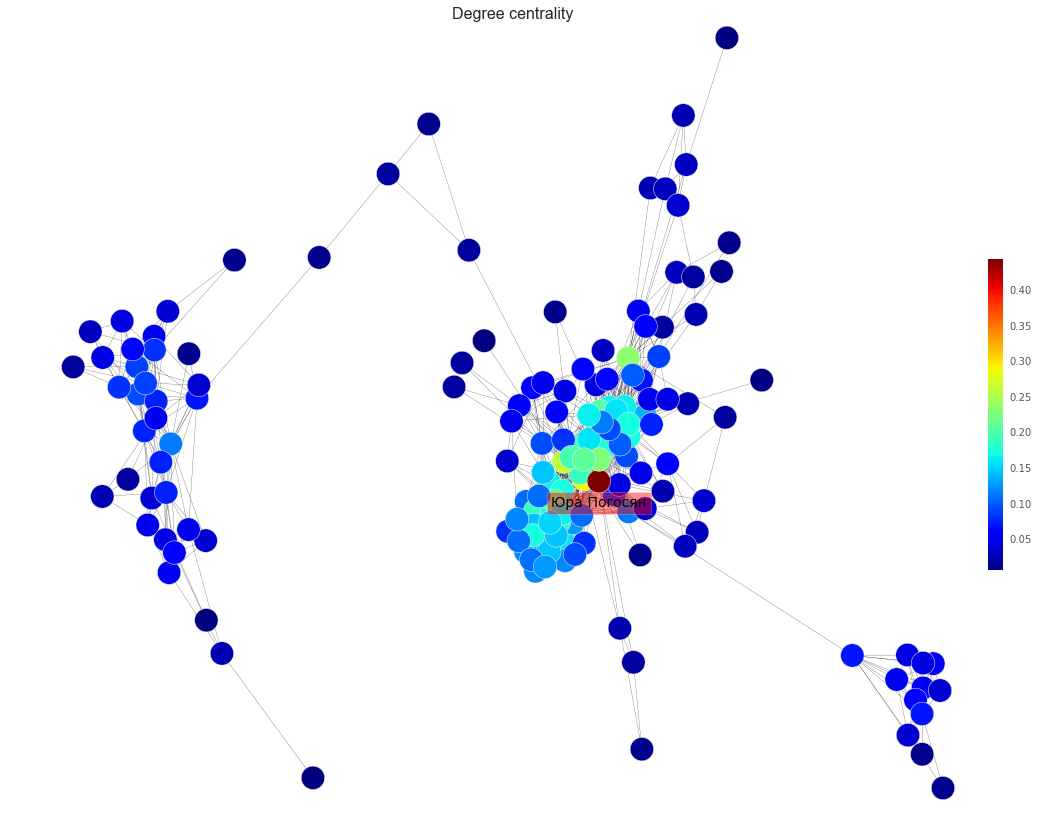

In [1393]:
plt.figure(figsize=(20,14))
degree_centr = nx.degree_centrality(Gc)
node_colors = list(degree_centr.values())

nodes = nx.draw_networkx_nodes(Gc, pos = coord, 
                               node_color=node_colors,
                               node_size = 550,
                               nodelist=list(degree_centr.keys()),
                               cmap = 'jet',
                               with_labels = False)
edges = nx.draw_networkx_edges(Gc, pos = coord, width = .2)
plt.xlim([-.95, .9])
plt.ylim([-.5, .6])
plt.colorbar(nodes, shrink=.4, pad=.0005, aspect=20)
plt.title('Degree centrality', fontsize = 16)
plt.axis("off")

top_nodes = sorted(degree_centr, key = degree_centr.get)[-3:]
# label the node with top degree centrality:
labels = nx.draw_networkx_labels(Gc, pos = {top_nodes[2]: coord[top_nodes[2]] + np.array([0., -0.03])}, 
                                 labels = {top_nodes[2]: Gc.node[top_nodes[2]]['name']}, 
                                 font_family="verdana", font_size = 14,
                                 bbox=dict(facecolor='red', alpha=0.45))

# print the results for top-3 nodes:
print("Top 1st node is", Gc.node[top_nodes[2]]['name'] + ", degree centrality: {:.2f} ".
      format(degree_centr[top_nodes[2]]))
print("Top 2nd node is", Gc.node[top_nodes[1]]['name'] + ", degree centrality: {:.2f} ".
      format(degree_centr[top_nodes[1]]))
print("Top 3rd node is", Gc.node[top_nodes[0]]['name'] + ", degree centrality: {:.2f} ".
      format(degree_centr[top_nodes[0]]))

The illustration is the same as above, the only difference is scale. 

* Top node is one of my best friends, who has metrics value 0.45 - it means that he knows around 45% of my friends, which is almost half of them.
*****

Continue with closeness centrality:

Top 1st node is Юра Погосян, closeness centrality: 0.37 
Top 2nd node is Глеб Коломиец, closeness centrality: 0.36 
Top 3rd node is Артём Семьянов, closeness centrality: 0.35 


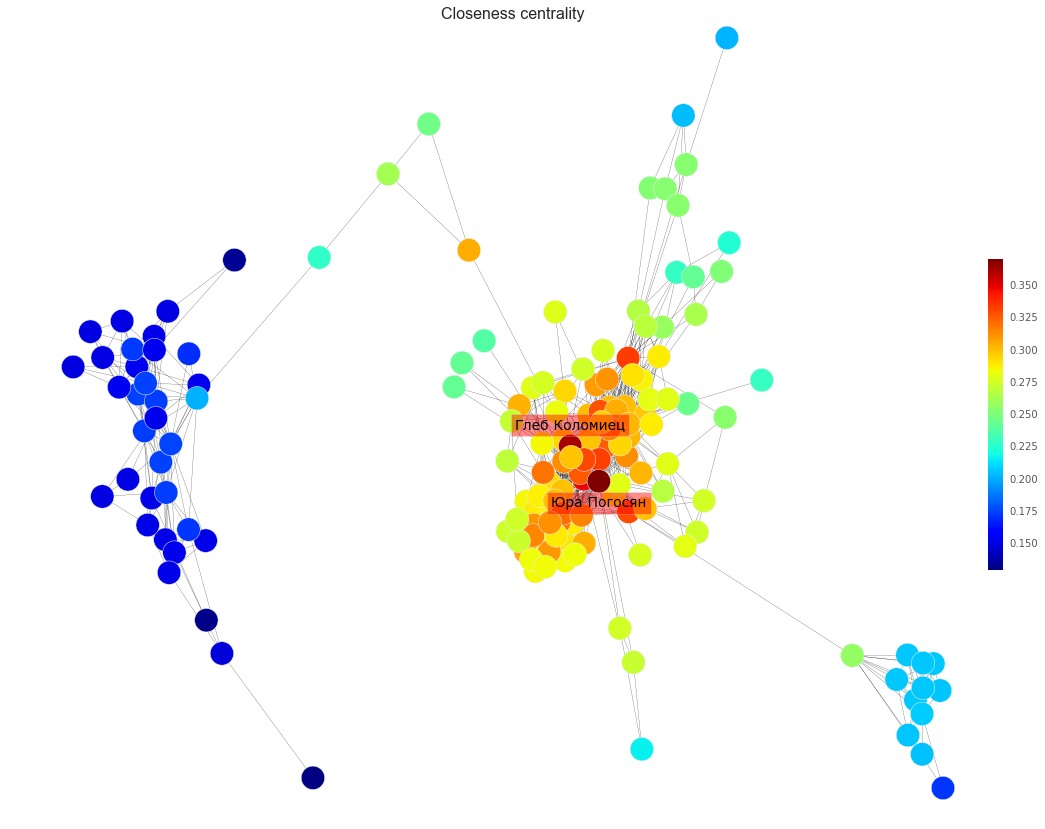

In [1389]:
plt.figure(figsize=(20,14))
closeness_centr = nx.closeness_centrality(Gc)
node_colors = list(closeness_centr.values())

nodes = nx.draw_networkx_nodes(Gc, pos = coord, 
                               node_color=node_colors,
                               node_size = 550,
                               nodelist=list(closeness_centr.keys()),
                               cmap = 'jet',
                               with_labels = False
                               )
edges = nx.draw_networkx_edges(Gc, pos = coord, width = .2)
plt.xlim([-.95, .9])
plt.ylim([-.5, .6])
plt.colorbar(nodes, shrink=.4, pad=.0005, aspect=20)
plt.title('Closeness centrality', fontsize = 16)
plt.axis("off")

top_nodes = sorted(closeness_centr, key = closeness_centr.get)[-3:]
labels = nx.draw_networkx_labels(Gc, pos = {top_nodes[2]: coord[top_nodes[2]] + np.array([0., -0.03]), 
                                            top_nodes[1]: coord[top_nodes[1]] + np.array([0., +0.03])}, 
                                     labels = {top_nodes[2]: Gc.node[top_nodes[2]]['name'], 
                                               top_nodes[1]: Gc.node[top_nodes[1]]['name']}, 
                                     font_family="verdana", font_size = 14,
                                     bbox=dict(facecolor='red', alpha=0.45))

print("Top 1st node is", Gc.node[top_nodes[2]]['name'] + ", closeness centrality: {:.2f} ".format(closeness_centr[top_nodes[2]]))
print("Top 2nd node is", Gc.node[top_nodes[1]]['name'] + ", closeness centrality: {:.2f} ".format(closeness_centr[top_nodes[1]]))
print("Top 3rd node is", Gc.node[top_nodes[0]]['name'] + ", closeness centrality: {:.2f} ".format(closeness_centr[top_nodes[0]]))

Closeness centrality indicates how far the node is from other nodes. Under this definition, there are much more nodes which have high value of this metrics. For example, the "gaps" between top nodes are minor:

* Top node is the same as one under degree centrality (one of my best friends) 
* The 2nd top node is famous head hunter
* Nodes in *small* communities have lower values, because they are further from the majority of nodes, which are in large community
****

Betweenness centrality can reveal which nodes make communities to be connected:

Top 1st node is Глеб Коломиец, betweenness centrality: 0.35 
Top 2nd node is Андрей Мартынов, betweenness centrality: 0.34 
Top 3rd node is Anton Djumaev, betweenness centrality: 0.34 


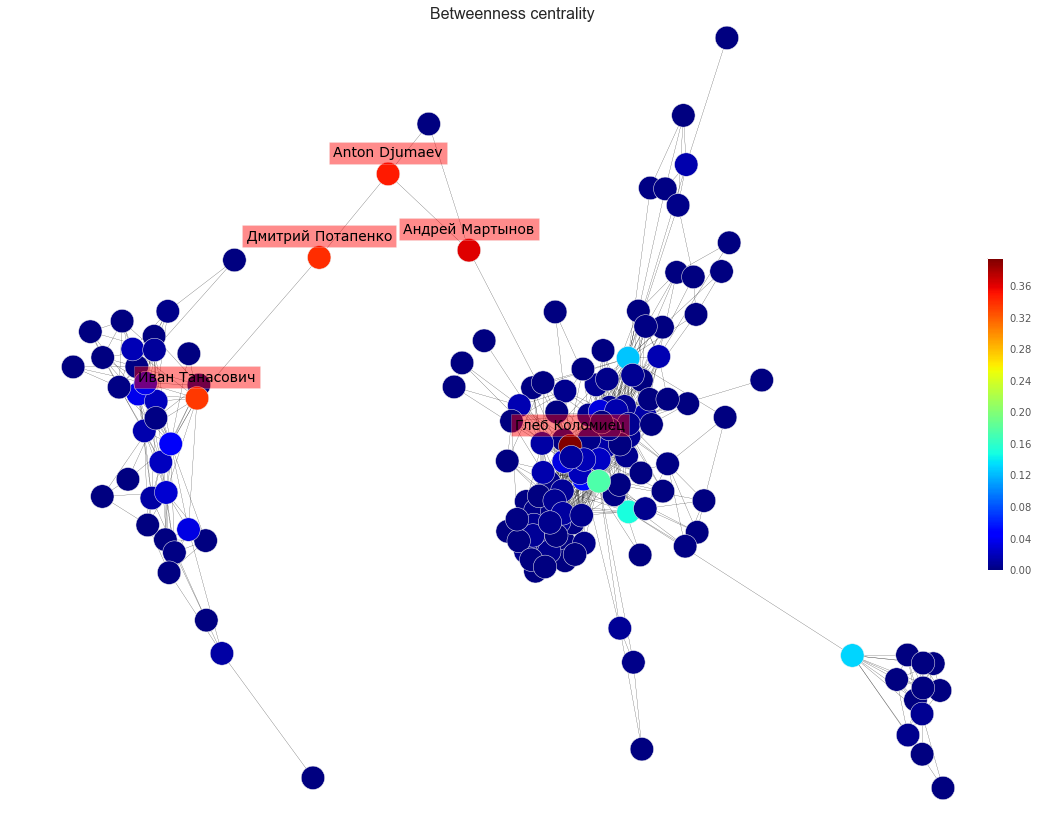

In [1387]:
plt.figure(figsize=(20,14))
between_centr = nx.betweenness_centrality(Gc)
node_colors = list(between_centr.values())

nodes = nx.draw_networkx_nodes(Gc, pos = coord, 
                               node_color=node_colors,
                               node_size = 550,
                               nodelist=list(between_centr.keys()),
                               cmap = 'jet',
                               with_labels = False
                               )
edges = nx.draw_networkx_edges(Gc, pos = coord, width = .2)
plt.xlim([-.95, .9])
plt.ylim([-.5, .6])
plt.colorbar(nodes, shrink=.4, pad=.0005, aspect=20)
plt.title('Betweenness centrality', fontsize = 16)
plt.axis("off")

top_nodes = sorted(between_centr, key = between_centr.get)[-5:]

labels = nx.draw_networkx_labels(Gc, pos = {top_nodes[4]: coord[top_nodes[4]] + np.array([0., 0.03]), 
                                            top_nodes[3]: coord[top_nodes[3]] + np.array([0., 0.03]), 
                                            top_nodes[2]: coord[top_nodes[2]] + np.array([0., 0.03]),
                                            top_nodes[1]: coord[top_nodes[1]] + np.array([0., 0.03]), 
                                            top_nodes[0]: coord[top_nodes[0]] + np.array([0., 0.03])}, 
                                 labels = {top_nodes[4]: Gc.node[top_nodes[4]]['name'], 
                                           top_nodes[3]: Gc.node[top_nodes[3]]['name'],
                                           top_nodes[2]: Gc.node[top_nodes[2]]['name'],
                                           top_nodes[1]: Gc.node[top_nodes[1]]['name'],
                                           top_nodes[0]: Gc.node[top_nodes[0]]['name']}, 
                                 font_family="verdana", font_size = 14,
                                 bbox=dict(facecolor='red', alpha=0.45))

print("Top 1st node is", Gc.node[top_nodes[4]]['name'] + ", betweenness centrality: {:.2f} ".format(between_centr[top_nodes[2]]))
print("Top 2nd node is", Gc.node[top_nodes[3]]['name'] + ", betweenness centrality: {:.2f} ".format(between_centr[top_nodes[1]]))
print("Top 3rd node is", Gc.node[top_nodes[2]]['name'] + ", betweenness centrality: {:.2f} ".format(between_centr[top_nodes[0]]))

High values are concentrated around few nodes, like with degree centrality metrics.
* Top node is head hunter, who personally might not be connected with many of my friends, but lies on many shortest paths
* Two communities (left one and large central) are connected because of one guy - 'Dmitry Potapenko' who is famous Russian businessman
* 3 friends who know the businessman, also have high metrics value (but in turn they are not famous at all!) 

***

**Pagerank. Comparison with centrality measures.**

Top 1st node is Юра Погосян, pagerank value: 0.026 
Top 2nd node is Данара Цедеева, pagerank value: 0.017 
Top 3rd node is Артём Семьянов, pagerank value: 0.016 


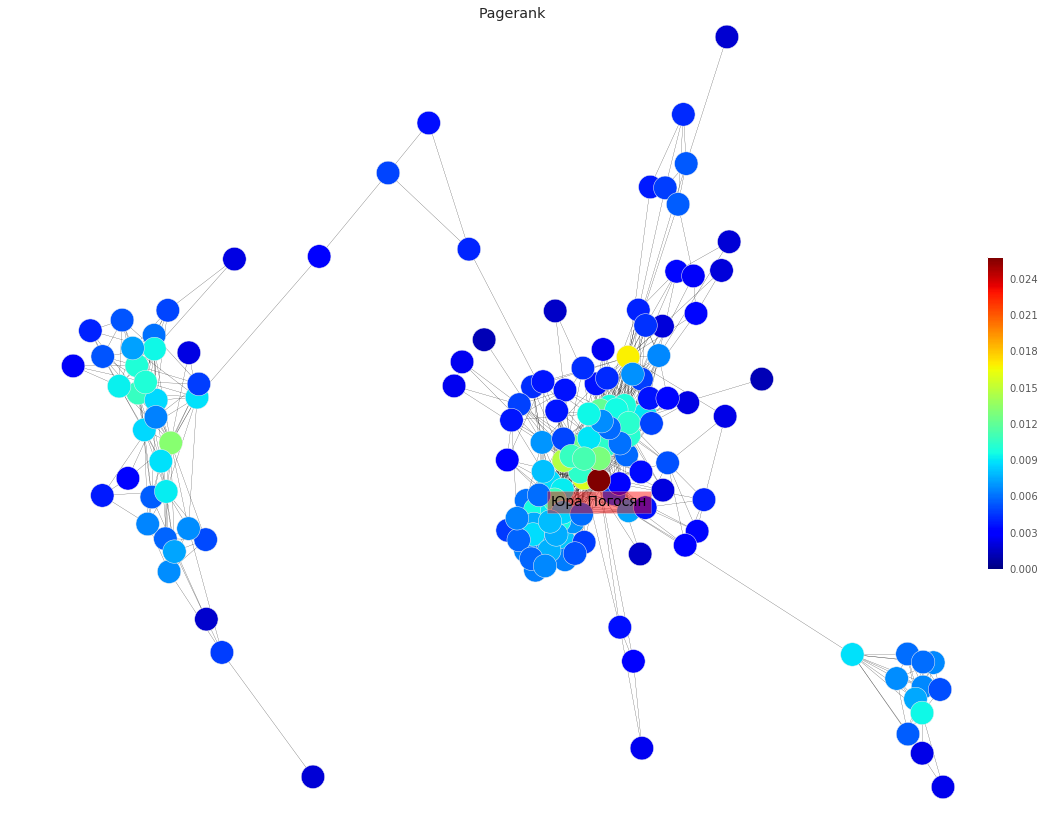

In [1384]:
plt.figure(figsize=(20,14))
page_rank = nx.pagerank(Gc)
node_colors = list(page_rank.values())

nodes = nx.draw_networkx_nodes(Gc, pos = coord, 
                               node_color=node_colors,
                               node_size = 550,
                               nodelist=list(page_rank.keys()),
                               cmap = 'jet',
                               with_labels = False,
                               vmin = 0.0)
edges = nx.draw_networkx_edges(Gc, pos = coord, width = .2)
plt.xlim([-.95, .9])
plt.ylim([-.5, .6])
plt.colorbar(nodes, shrink=.4, pad=.0005, aspect=20)
plt.title('Pagerank')
plt.axis("off")

top_nodes = sorted(page_rank, key = page_rank.get)[-3:]

labels = nx.draw_networkx_labels(Gc, pos = {top_nodes[2]: coord[top_nodes[2]] + np.array([0., -0.03])}, 
                                     labels = {top_nodes[2]: Gc.node[top_nodes[2]]['name']}, 
                                     font_family="verdana", font_size = 14,
                                     bbox=dict(facecolor='red', alpha=0.45))

print("Top 1st node is", Gc.node[top_nodes[2]]['name'] + ", pagerank value: {:.3f} ".format(page_rank[top_nodes[2]]))
print("Top 2nd node is", Gc.node[top_nodes[1]]['name'] + ", pagerank value: {:.3f} ".format(page_rank[top_nodes[1]]))
print("Top 3rd node is", Gc.node[top_nodes[0]]['name'] + ", pagerank value: {:.3f} ".format(page_rank[top_nodes[0]]))

Pagerank values are generally the same as degree centrality, but distributed more evenly.
* Top node is still the same as in degree and closeness centralities
* Nodes in small communities nevertheless can have pretty high pagerank values

Comparison of metrics:

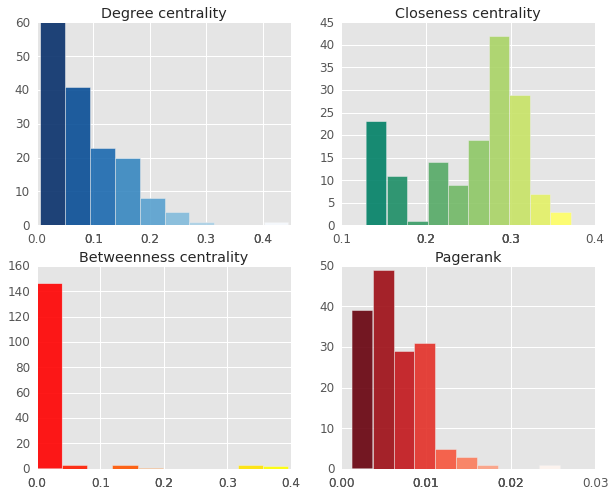

In [1202]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Degree centrality", y = 1.00)
plot_hist(data = list(degree_centr.values()), colormap = 'Blues_r', alpha = 0.9, bins = 10, round_value=1)

plt.subplot(2, 2, 2)
plt.title("Closeness centrality", y = 1.00)
plot_hist(data = list(closeness_centr.values()), colormap = 'summer', alpha = 0.9, bins = 10, round_value=1)

plt.subplot(2, 2, 3)
plt.title("Betweenness centrality", y = 1.00)
plot_hist(data = list(between_centr.values()), colormap = 'autumn', alpha = 0.9, bins = 10)

plt.subplot(2, 2, 4)
plt.title("Pagerank", y = 1.00)
plot_hist(data = list(page_rank.values()), colormap = 'Reds_r', alpha = 0.9, bins = 10, round_value=2)

All the metrics' values are distributed very differently:
* Degree centrality has the same distribution as just degree distribution and might have power-law nature
* Closeness centrality tends to be symmetrical and gaussian-shaped
* Betweenness centrality skewed too much and might be exponential - like
* Pagerank more or less looks like degree centrality metrics, however more uniform in the first semirange

****

**Assortative mixing**

In [454]:
assortativities = []
# degree assortativity is the easiest to calculate:
assort_degree = nx.degree_assortativity_coefficient(Gc)
assortativities.append(assort_degree)
print('Degree assortativity coefficient: {:.2f}'.format(assort_degree))

# attribute assortativity coefficients:
attr = ['university_name', 'city', 'sex']
for a in attr:
    H = Gc.copy()
    for n in H.nodes():
        # calculate assortativity only for those nodes which don't have missing values:
        if H.node[n][a] == 'NA':
            H.remove_node(n)
    assort = nx.attribute_assortativity_coefficient(H, a)
    assortativities.append(assort)
    print("Assortativity by attribute", a, ": {:.2f}".format(assort))

Degree assortativity coefficient: 0.14
Assortativity by attribute university_name : 0.23
Assortativity by attribute city : 0.31
Assortativity by attribute sex : 0.08


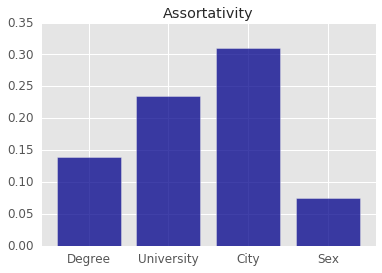

In [1366]:
plt.bar(list(range(4)), assortativities, facecolor = 'darkblue', alpha = 0.75)
plt.xticks(np.arange(4) + 0.4, ['Degree', 'University', 'City', 'Sex'], fontsize = 12)
plt.yticks(fontsize=12)
plt.xlim([-0.2, 4])
plt.title('Assortativity')

The networks is assortative:
* City and university attributes are the most influential to make connections b/w nodes - it is clear
* Degree value is still important but not so much. 
* Sex might be not significant at all.

These conclusions might be biased for the overall VK network, because only mutual connections are really analysed. For example, the businessman has just 2 connections here and he is connected with also low-degree nodes. Thus he has high degree assortativity value. But in reality, he has 1000 friends who in turn have not so many connections -> the businessman must have actual high negative degree assortativity value.  
****

**Node structural equivalence/similarity:**

Let's take a look how similar are nodes in terms of mutual connection patterns.

(array([ -20.,    0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.]),
 <a list of 10 Text yticklabel objects>)

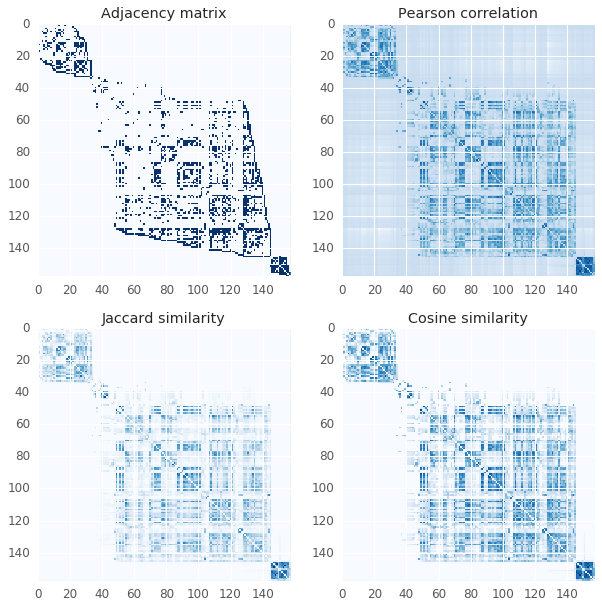

In [617]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
# reorder rows and cols of adjacency matrix for better visualization:  
cm = nx.utils.reverse_cuthill_mckee_ordering(Gc)
nodes_permut = list(cm)
A = nx.to_numpy_matrix(Gc, nodelist=nodes_permut, dtype=int)
A = np.asarray(A)
plt.imshow(A, cmap = 'Blues', interpolation = 'None')
plt.title("Adjacency matrix")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Pearson correlation coefficient:
plt.subplot(2, 2, 2)
D = np.corrcoef(A)
D = np.nan_to_num(D)
plt.imshow(D, cmap = 'Blues', interpolation = 'None')
np.fill_diagonal(D, 0)
plt.title("Pearson correlation")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Jaccard similarity:
plt.subplot(2, 2, 3)
J = 1 - sp.spatial.distance.pdist(A, 'jaccard')
J = np.nan_to_num(J)
J = sp.spatial.distance.squareform(J)
plt.imshow(J, cmap = 'Blues', interpolation = 'None')
plt.title("Jaccard similarity")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# cosine similarity:
plt.subplot (2, 2, 4)
C = 1 - sp.spatial.distance.pdist(A, 'cosine')
C = np.nan_to_num(C)
C = sp.spatial.distance.squareform(C)
plt.imshow(C, cmap = 'Blues', interpolation = 'None')
plt.title("Cosine similarity")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

* Adjacency matrix and similarity metrics clearly indicate presence of 3 clusters
* All the similarity metrics give in fact the same visual output - look at top 3 pairs of nodes below:

In [482]:
similarity_metrics = [D, J, C]
metrics_labels = ['Pearson', 'Jaccard', 'Cosine']

for i in range(len(metrics_labels)):
    metric = similarity_metrics[i]
    metric_label = metrics_labels[i]
    ind_sort = np.argsort(metric.ravel())
    print("Highest", metric_label, "correlation values:")
    for j in [-1, -3, -5]:
        ind_1d = ind_sort[j]
        ind_2d = np.unravel_index(ind_1d, D.shape)
        node1_name = Gc.node[str(nodes_permut[list(ind_2d)[0]])]['name']
        node2_name = Gc.node[str(nodes_permut[list(ind_2d)[1]])]['name']
        value = metric[ind_2d]
        print("   ", node1_name, node2_name, '{:.2f}'.format(value))
    print("\n")

Highest Pearson correlation values:
    Полина Иванова Василий Рубцов 0.93
    Анастасия Игнатьева Амир Сафиуллин 0.92
    Марина Боярова Ян Соколов 0.89


Highest Jaccard correlation values:
    Василий Рубцов Полина Иванова 0.88
    Анастасия Игнатьева Амир Сафиуллин 0.86
    Ян Соколов Марина Боярова 0.80


Highest Cosine correlation values:
    Полина Иванова Василий Рубцов 0.94
    Анастасия Игнатьева Амир Сафиуллин 0.93
    Марина Боярова Ян Соколов 0.89




*****

**Random graphs models similar to SN**

Take into consideration 3 basic random graph models:
* Erdos - Renyi
* Barabasi - Albert
* Small world

And 3 basic properties of network to compare them:
* average clustering coefficient
* diameter
* degree distribution

Additionally, let each of them has the same number of nodes and edges.

In [586]:
# calculate again key properties of VK network:
clust_Gc = nx.average_clustering(Gc)
diam_Gc = nx.diameter(Gc)
degr_Gc = np.array(list(Gc.degree().values()))

In [588]:
# Erdos-Renyi model:
G_erdos = nx.gnm_random_graph(n = len(Gc.nodes()), 
                              m = len(Gc.edges()))

# key properties of Erdos-Renyi model:
clust_erdos = nx.average_clustering(G_erdos)
diam_erdos = nx.diameter(G_erdos)
degr_erdos = np.array(list(G_erdos.degree().values()))

Small world model must have extra parameter as an input - *probability* for edge to be rewired. Let's find optimal parameter to make the small-world network be as similar to the VK network as possible (in terms of average clustering coefficient and diameter):

In [589]:
# the array of probabilities among which the optimal one will be found:
p_list = np.arange(0.01, 0.9, 0.01)

def optimal_proba(graph_type, p_list):
    # initialize the optimization metrics and current properties with some bad values:
    delta = 2
    clust_small_world = 0
    diam_small_world = 0
    for p in p_list:
        # create graph for each probability:
        G = graph_type(n = len(Gc.nodes()), 
                       k = round(len(Gc.edges()) / len(Gc.nodes())),
                       p = p, 
                       seed = 42)
        # calculate current graph properties:
        current_diam = nx.diameter(G)
        current_clust = nx.average_clustering(G)
        # the deviation from VK properties is the sum of relative deviations:
        current_delta = abs(current_diam - diam_Gc) / diam_Gc + \
                        abs(current_clust - clust_Gc) / clust_Gc
        # replace last properties with current ones of they are better:
        if current_delta < delta:
            delta = current_delta
            clust_small_world = current_clust
            diam_small_world = current_diam
            degr_small_world = np.array(list(G.degree().values()))
    return clust_small_world, diam_small_world, degr_small_world

# key properties of Small-world model:
clust_small_world = optimal_proba(nx.watts_strogatz_graph, p_list)[0]
diam_small_world = optimal_proba(nx.watts_strogatz_graph, p_list)[1]
degr_small_world = optimal_proba(nx.watts_strogatz_graph, p_list)[2]

In [590]:
# Barabasi-Albert model:
G_barab = nx.barabasi_albert_graph(n = len(Gc.nodes()), 
                                   m = round(len(Gc.edges()) / len(Gc.nodes())),
                                   seed = 42)

# key properties of Barabasi-Albert model:
clust_barab = nx.average_clustering(G_barab)
diam_barab = nx.diameter(G_barab)
degr_barab = np.array(list(G_barab.degree().values()))

In [600]:
# create dataframe to collect all things into one place:
df_randmodels = pd.DataFrame(data = {'aver_clustering': [clust_Gc, clust_erdos, clust_barab, clust_small_world], 
                                     'diameter': [diam_Gc, diam_erdos, diam_barab, diam_small_world]},
                             index = ['VK network', 'Erdos-Renyi', 'Barabasi-Albert', 'Small World'])

In [1187]:
df_randmodels.round(decimals=2)

,aver_clustering,diameter
VK network,0.59,11
Erdos-Renyi,0.08,4
Barabasi-Albert,0.17,3
Small World,0.57,12


The best approximating model under given natural constraints (number of nodes, edges) is *Small World* model.
It has almost identical to VK network diameter and average clustering coefficient because probability parameter might be optimized to achiev this goal!

What about degree distribution?

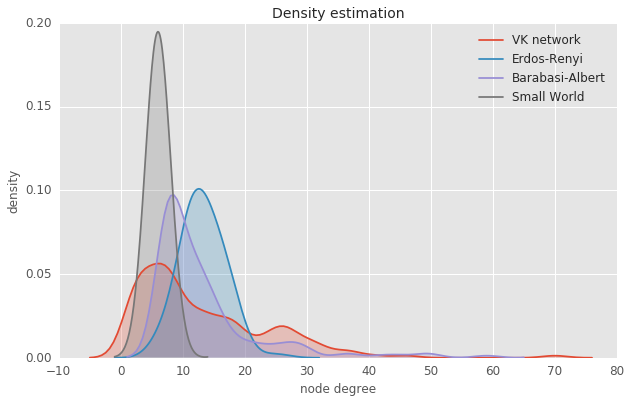

In [794]:
plt.figure(figsize=(10,6))
sns.kdeplot(degr_Gc, shade = True, label = 'VK network', bw = 2)
sns.kdeplot(degr_erdos, shade = True, label = 'Erdos-Renyi', bw = 2)
sns.kdeplot(degr_barab, shade = True, label = 'Barabasi-Albert', bw = 2)
sns.kdeplot(degr_small_world, shade = True, label = 'Small World', bw = 2)
plt.legend(fontsize = 12)
plt.xlabel(font)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('node degree')
plt.ylabel('density')
plt.title('Density estimation', fontsize = 14)

Under theory and as here shown, degree distribution in Small World and Erdos-Renyi models have Pareto - like nature, which is not appropriate for social networks. In particular, in Small world model the degree values are very concentrated around its mean value. 

If this fact is crucial, then *Barabasi-Albert* model must chosen as it has underlying power-law degree distribution.
****

### 2. Community detection.

**Clique search.**

Firstly, find all cliques in graph and size of maximum clique:

In [1244]:
print('Number of cliques -', nx.graph_number_of_cliques(Gc))
print('Graph clique number -', nx.graph_clique_number(Gc))

# all cliques in one list:
cliques_all = list(nx.find_cliques(Gc))
# all clique sizes in one list:
cliques_all_sizes = [len(x) for x in cliques_all if len(x) > 3]
# elements of the largest clique
cliques_12 = [clique for clique in cliques_all if len(clique) == max(cliques_all_sizes)]
# dictionary to associate nodes with their names:
labels_clique_12 = {k:Gc.node[k]['name'] for k in cliques_12[0]}

pos_clique = np.array([[0.6, -.1]] * 12)
for i in range(12):
    pos_clique[i] += [0, i * 0.025]
pos_clique_12 = dict(zip(cliques_12[0], pos_clique))

Number of cliques - 537
Graph clique number - 12


([<matplotlib.axis.XTick at 0x1532be5f8>,
 <a list of 9 Text xticklabel objects>)

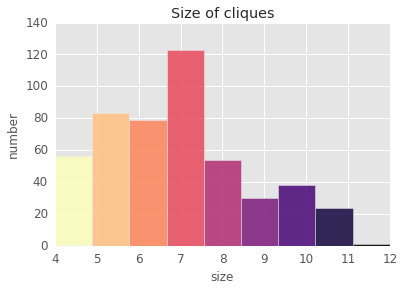

In [1239]:
plot_hist(data = cliques_all_sizes, colormap = 'magma_r', alpha = 0.9, bins = 9)
plt.title('Size of cliques')
plt.xlabel('size', fontsize = 12)
plt.ylabel('number', fontsize = 12)
plt.xticks(np.arange(min(cliques_all_sizes), max(cliques_all_sizes) + 1, 1))

The maximum clique size is 12. Depict it on the graph with respectful labels of nodes:

(-0.94999999999999996, 0.90000000000000002, -0.5, 0.59999999999999998)

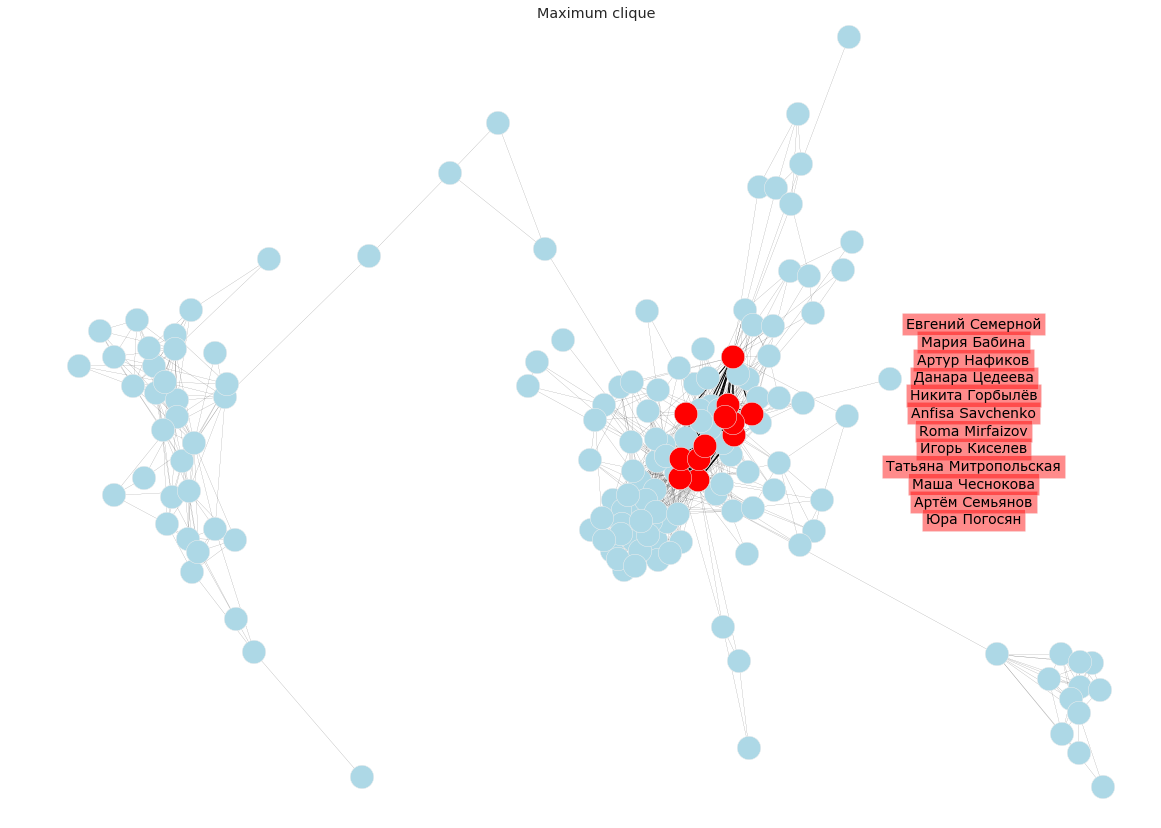

In [1397]:
plt.figure(figsize=(20,14))

nx.draw_networkx(Gc, pos = coord,
                 node_color = 'lightblue',
                 node_size = 550,
                 with_labels = False,
                 width = 0.1)

nx.draw_networkx_nodes(Gc, pos = coord, 
                       nodelist = cliques_12[0],
                       node_size = 550,
                       node_color = 'r')

nx.draw_networkx_edges(Gc, pos = coord, 
                       width = 1,
                       edgelist = list(combinations(cliques_12[0], 2)))

nx.draw_networkx_labels(Gc, pos = pos_clique_12, 
                        labels = labels_clique_12, 
                        font_family = "verdana", font_size = 14,
                        bbox=dict(facecolor = 'red', alpha = 0.45))


plt.xlim([-.95, .9])
plt.ylim([-.5, .6])
plt.title('Maximum clique')
plt.axis("off")

The maximum clique has clear interpretation: there are people who lived at the same HSE dorm on the 5th floor!

**K-shells.**

Depict K-shells to better understand network structure:

(-0.94999999999999996, 0.90000000000000002, -0.5, 0.59999999999999998)

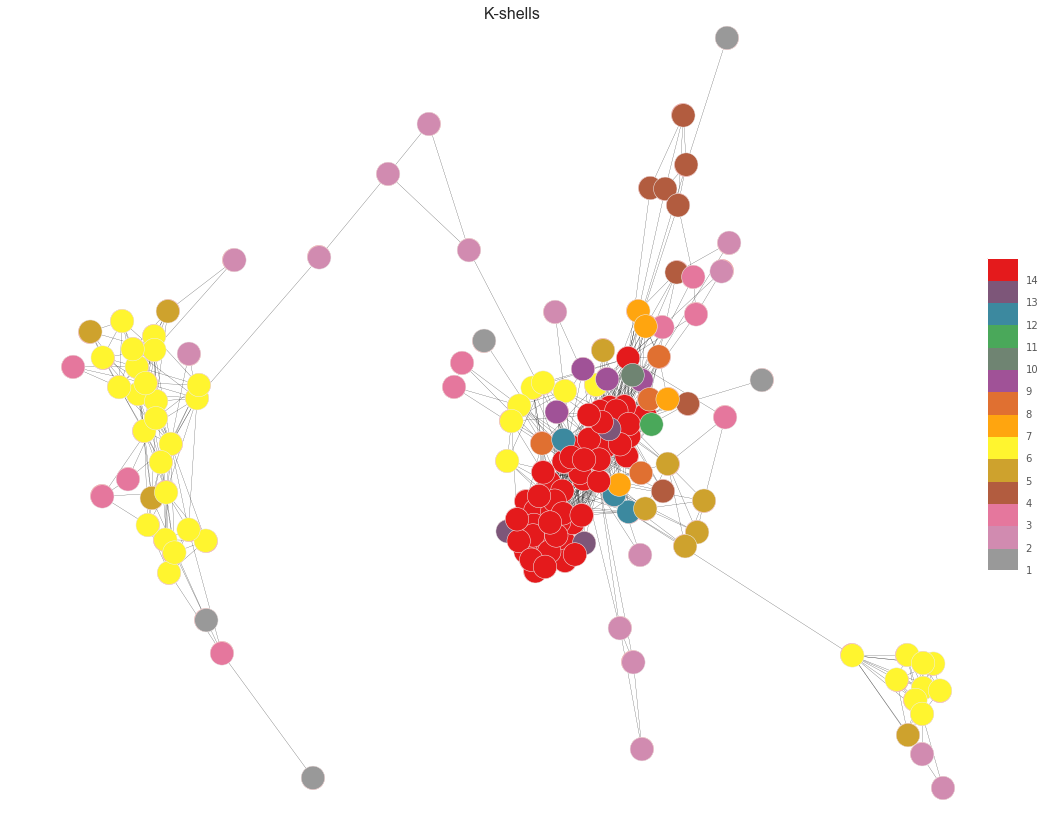

In [1398]:
cores_dict = nx.core_number(Gc)
plt.figure(figsize=(20,14))
nx.draw_networkx(Gc, pos = coord,
                 node_size = 550,
                 with_labels = False,
                 width = 0.2)

nodes = nx.draw_networkx_nodes(Gc, pos = coord,
                       nodelist = list(cores_dict.keys()),
                       node_size = 550,
                       node_color = list(cores_dict.values()),
                       vmin = min(cores_dict.values()),
                       vmax = max(cores_dict.values()),
                       cmap = 'Set1_r')

plt.colorbar(nodes, shrink=.4, pad=.0005, aspect=10, values = list(range(1, 16, 1)), 
            ticks = list(range(1, 15, 1)), boundaries = list(range(1, 16, 1)))

plt.xlim([-.95, .9])
plt.ylim([-.5, .6])
plt.title('K-shells', fontsize = 16)
plt.axis("off")

In [1258]:
core_max = [Gc.node[x]['name'] for x in cores_dict.keys() if cores_dict[x] == max(cores_dict.values())]
print(len(core_max), core_max)

51 ['Артём Семьянов', 'Сергей Кузнецов', 'Виталик Главчанский', 'Татьяна Митропольская', 'Виктор Безруков', 'Никита Ивато', 'Валентин Чадин', 'Roma Mirfaizov', 'Аделя Шарафеева', 'Илья Морозов', 'Дима Попов', 'Игнат Усок', 'Данара Цедеева', 'Anfisa Savchenko', 'Илья Ерыженский', 'Максим Журавлев', 'Артём Сорокин', 'Валерия Колобашкина', 'Егор Козлов', 'Глеб Коломиец', 'Дарья Арутюнова', 'Кевин Офорий', 'Антон Абдухамидов', 'Евгений Семерной', 'Саша Николаев', 'Лена Карева', 'Евгений Шилов', 'Серёга Козлов', 'Юра Погосян', 'Тимур Герейханов', 'Эдвард Бахитов', 'Анастасия Соболева', 'Kseniya Zherebtsova', 'Евгений Литвиненко', 'Ксения Давыдова', 'Мария Бабина', 'Ксения Задорожная', 'Артур Нафиков', 'Alena Kislyanskaya', 'Малика Азамбаева', 'Стася Хвастунова', 'Илья Семенов', 'Анатолий Ширыкалов', 'Игорь Киселев', 'Анна Куликова', 'Наталия Краснопеева', 'Никита Горбылёв', 'Катя Хаменская', 'Савелий Карпухин', 'Михаил Абрамов', 'Маша Чеснокова']


The most dense part of the graph comprise k-shell with k = 14. There are 51 people there, all of them, apart from one, studied together at HSE and/or lived at the same dorm.
*****

**Community detection algorithms.**

The essential part of the network analysis - community detection. One can apply various algorithms optimizing particular metrics. In this case, I'd like to use *modularity* as criterion of quality.

K-clique percolation algorithm takes size of clique as an input parameter. It can be picked to maximize modularity.

In [1291]:
k_list = list(range(2, 8))

# find optimal parameter 'k' for K-clique percolation algorithm:
def optimal_k(k_list):
    # initialize modularity with any bad value:
    modular = 0
    # iterate over k-values:
    for k in k_list:
        k_cliq_comm = list(nx.k_clique_communities(Gc, k))
        # dictionary to color nodes:
        colors_k_cliq = {}
        for i in range(len(k_cliq_comm)):
            for j in k_cliq_comm[i]:
                colors_k_cliq[j] = i
        G_comm = Gc.copy()
        # K-clique doesn't assign community number to some nodes - they must be removed to calculate modularity:
        G_comm.remove_nodes_from(list(set(Gc.nodes()).difference(set(colors_k_cliq.keys()))))
        # if in-cycle current modularity is better than last one, replace it:
        if modularity(colors_k_cliq, G_comm) > modular:
            partition = colors_k_cliq
            modular = modularity(colors_k_cliq, G_comm)
    print ('max modularity: {:.2f}'.format(modular))
    return [partition, modular]

In [1292]:
# find communities, their number and modularity value using optimal K: 
colors_k_cliq, modular_kcliq = optimal_k(k_list)
ncomm_kcliq = len(set(colors_k_cliq.values()))

max modularity: 0.31


In [1424]:
def plot_communities(nodes_dict):
    plt.figure(figsize=(20,14))
    nx.draw_networkx(Gc, pos = coord,
                     node_size = 550,
                     with_labels = False,
                     width = 0.2)

    nodes = nx.draw_networkx_nodes(Gc, pos = coord,
                           nodelist = list(nodes_dict.keys()),
                           node_size = 550,
                           node_color = list(nodes_dict.values()),
                           vmin = min(nodes_dict.values()),
                           vmax = max(nodes_dict.values()),
                           cmap = 'Set1_r')

    nx.draw_networkx_labels(Gc, pos = coord, 
                            labels = {x: (Gc.node[x]['name']).split()[1] for x in Gc.nodes()}, 
                            font_family="verdana", font_size = 7)

    plt.xlim([-.95, .9])
    plt.ylim([-.5, .6])
    plt.axis("off")

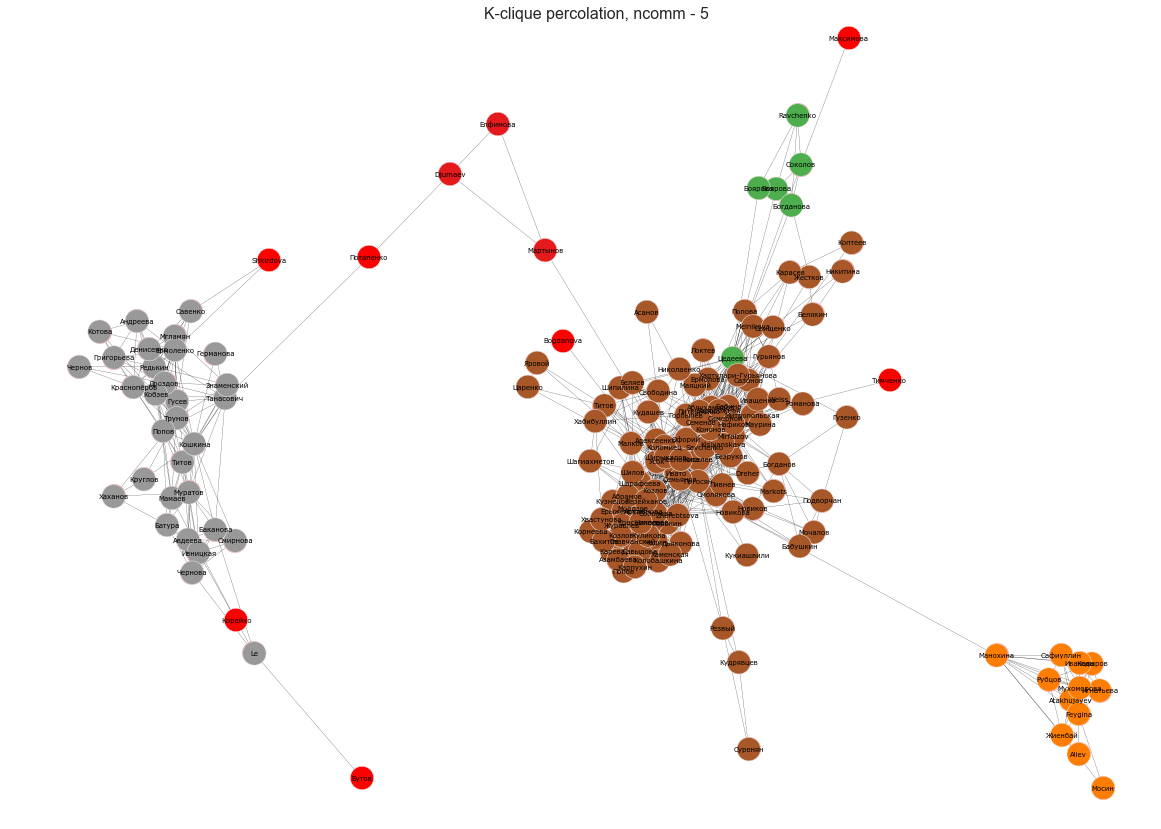

In [1425]:
plot_communities(colors_k_cliq)
plt.title('K-clique percolation, ncomm - {}'.format(ncomm_kcliq), fontsize = 16)

People, who don't belong to any community, are colored in red. There are 4 communities:
* Hometowns (grey) 
* Family (green)
* Current university (orange)
* Others - previous university, work, few random people (brown)


I don't like these results, because:
* there are only 4 communities
* few people are misclassified (don't have labels, however they must be in one of the defined communities)

There is 1 funny and important thing - K-clique percolation is the only algorithm which detects my girlfriend as my family member!

*Louvain algorithm:*

In [1294]:
# create partition and calculate modularity:
partition_louv = best_partition(Gc)
modular_louv = modularity(partition_louv, Gc)
ncomm_louv = len(set(partition_louv.values()))
print('max modularity: {:.2f}'.format(modular_louv))

max modularity: 0.51


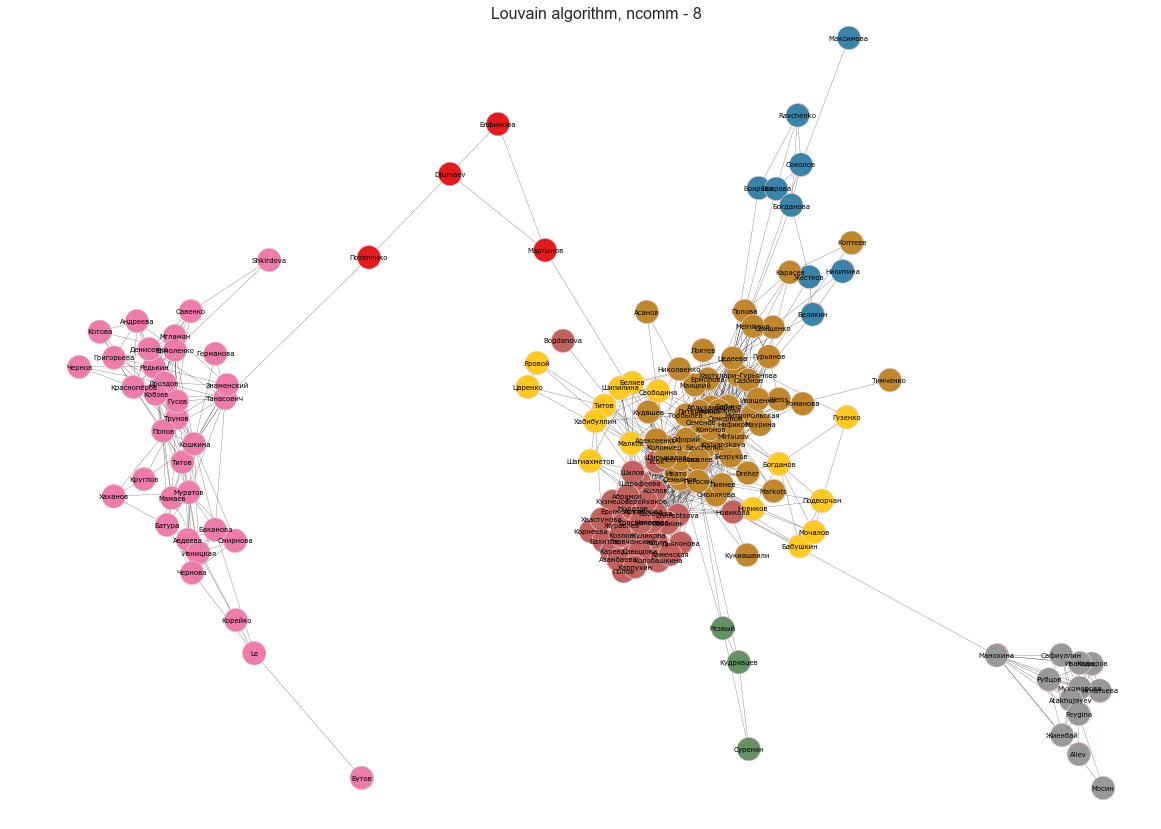

In [1410]:
plot_communities(partition_louv)
plt.title('Louvain algorithm, ncomm - {}'.format(ncomm_louv), fontsize = 16)

The modularity value is much better than in K-clique percolation.

There are 8 clusters:
* Hometowns (pink)
* Family + *random friends* (??, blue)
* Course mates
* Dormitory + *random friends* (??)
* Work + *random friends* (??)
* Guys from Latvia (green)
* Current university (grey)
* People - bridges (red)

The better modularity means nothing. There are many mistakes which I don't like!

*Spectral modularity optimization:*

In [1297]:
# re-create graph in igraph module format:
Gc_igraph = igraph.Graph()
Gc_igraph.add_vertices(Gc.nodes())
Gc_igraph.add_edges(Gc.edges())

# create partition and calculate modularity:
partition_spectral = Gc_igraph.community_leading_eigenvector()
modular_spectr = partition_spectral.modularity
print('max modularity: {:.2f}'.format(partition_spectral.modularity))

nodes_values = {k: Gc.nodes()[k] for k in range(Gc.order())}
colors_spectral = {}
for i in range(len(list(partition_spectral))):
    for j in list(partition_spectral)[i]:
        colors_spectral[nodes_values[j]] = i
ncomm_spectr = len(set(colors_spectral.values()))

max modularity: 0.48


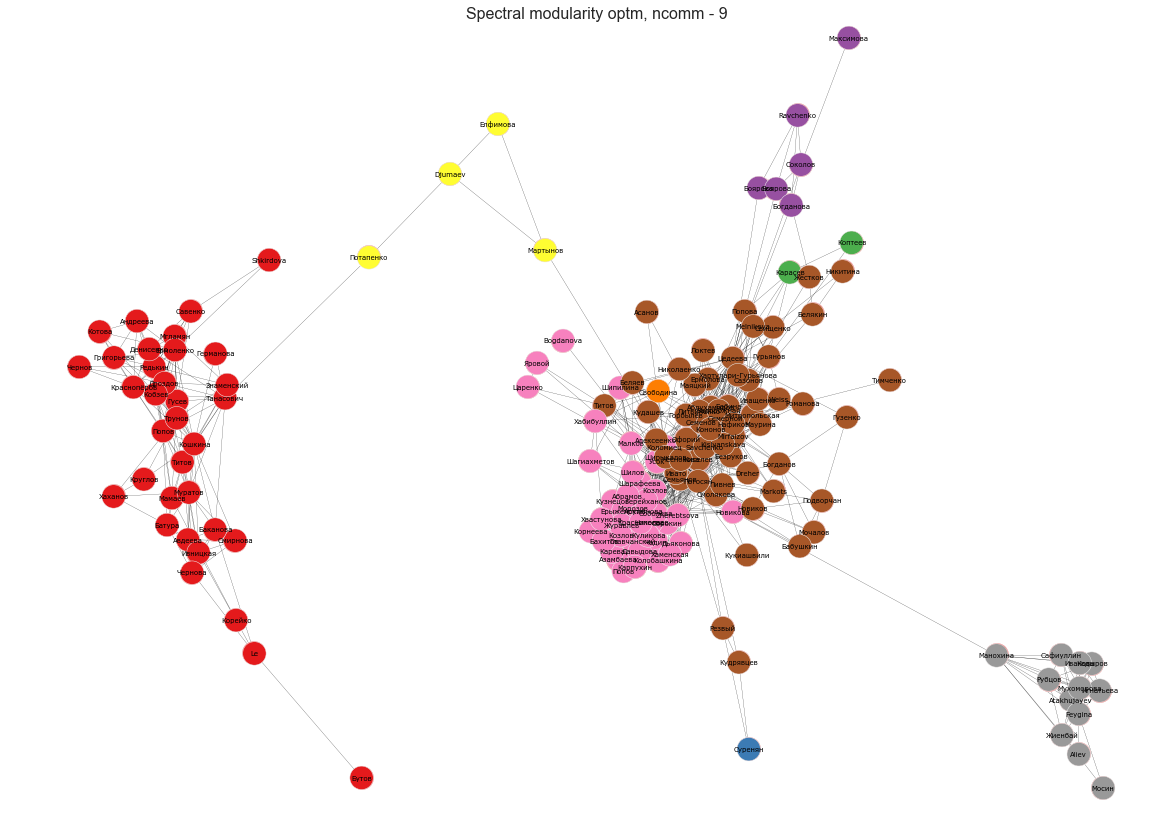

In [1411]:
plot_communities(colors_spectral)
plt.title('Spectral modularity optm, ncomm - {}'.format(ncomm_spectr), fontsize = 16)

There are even more communities and similar modularity! The communities are little bit different from the Louvain algorithm:
* Only 1 guy from Latvia now (instead of 3, blue)
* No 'work' community here
* Correct 'family' community
* 2 random guys which I met at sauna (Wow!)
* The girl who comprises separate community (??)

All in all, it is better in some things but worse at others in comparison with Louvain.

*Walktrap algorithm:*

In [1299]:
# find partition, modularity:
partition_walktrap = Gc_igraph.community_walktrap(steps = 5)
partition_walktrap = partition_walktrap.as_clustering()
modular_walktrap = partition_walktrap.modularity
print('max modularity: {:.2f}'.format(partition_walktrap.modularity))

colors_walktrap = {}
for i in range(len(list(partition_walktrap))):
    for j in list(partition_walktrap)[i]:
        colors_walktrap[nodes_values[j]] = i
ncomm_walktrap = len(set(colors_walktrap.values()))

max modularity: 0.46


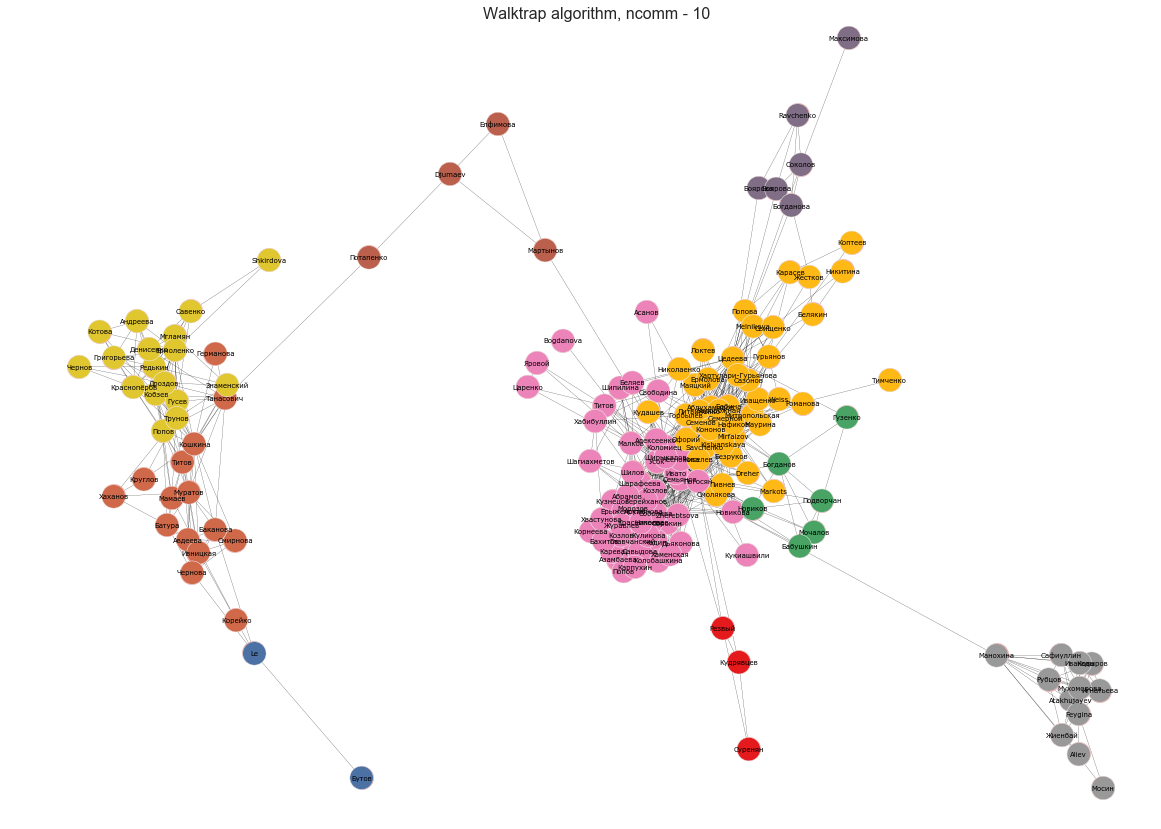

In [1418]:
plot_communities(colors_walktrap)
plt.title('Walktrap algorithm, ncomm - {}'.format(ncomm_walktrap), fontsize = 16)

10 communities with little bit worse modularity score. I like this algorithm the most, because:
* It correctly separates 1st hometown from the 2nd one (it is hard - many people know each other!)
* 'Work' cluster is correct (green)
* Family and Latvian guys sre correct! (red)

There are just 2 nodes which could be better to refer to the hometown community (blue), but they somehow represent separate cluster!

*Markov clustering algorithm:*

In [1301]:
# the function to perform clustering:
def MCL(A, tol, p, alpha):
    step = 1
    col_sums = A.sum(axis = 0)
    T = A / col_sums[np.newaxis, :]
    M = T
    while(1):
        step += 1
        # Expansion step:
        M1 = np.linalg.matrix_power(M, p)
        # Inflation step:
        M1 = np.power(M1, alpha)
        col_sums = M1.sum(axis = 0)
        M1 = M1 / col_sums[np.newaxis, :]
        M1[M1<=tol] = 0
        if np.linalg.norm(M - M1) == 0:
            return M1
        else:
            M = M1.copy()

In [1304]:
A = nx.adjacency_matrix(Gc)
A = A.toarray()

tols = [0.01, 0.02]
p_values = [2, 3, 4]
alphas = [2, 3, 4]
ncomm_max = 10
modular_MCL = 0
partition_MCL = {}

for t in tols:
    for p in p_values:
        for a in alphas:
            CM = MCL(A, tol = t, p = p, alpha = a)
            partition_CM = {}
            for i in range(CM.shape[0]):
                partition_CM[Gc.nodes()[i]] = np.ix_(CM[:, i] == 1)[0][0]
            modular = modularity(partition_CM, Gc)
            if modular > modular_MCL and len(set(partition_CM.values())) <= ncomm_max:
                modular_MCL = modular
                partition_MCL = partition_CM
print('max modularity: {:.2f}'.format(modular_MCL))

ncomm_MCL = len(set(partition_MCL.values()))

max modularity: 0.31


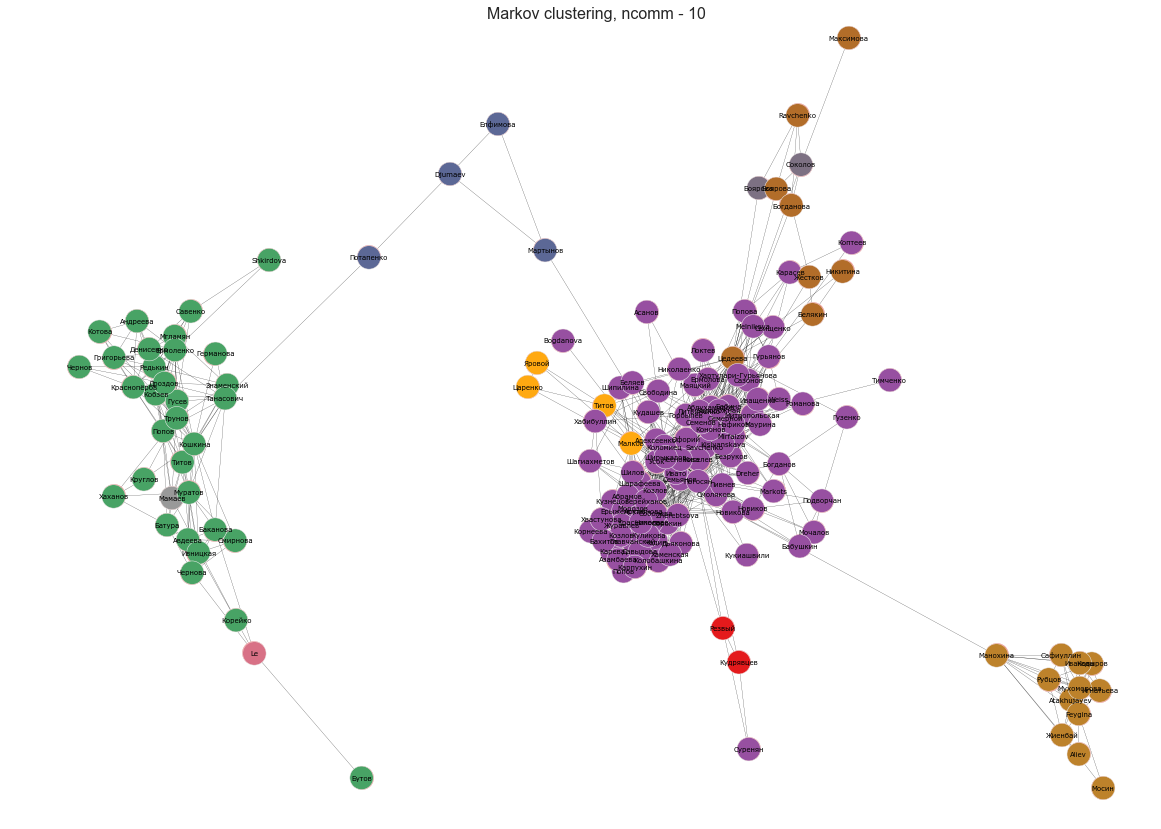

In [1422]:
plot_communities(partition_MCL)
plt.title('Markov clustering, ncomm - {}'.format(ncomm_MCL), fontsize = 16)

There are many mistakes - this algorithm is the worst one!

*Label propagation algorithm:*

In [1306]:
# partition, modularity:
partition_label_prop = Gc_igraph.community_label_propagation()
modular_label_prop = partition_label_prop.modularity
print('max modularity: {:.2f}'.format(partition_spectral.modularity))

nodes_values = {k: Gc.nodes()[k] for k in range(Gc.order())}
colors_label_prop = {}
for i in range(len(list(partition_label_prop))):
    for j in list(partition_label_prop)[i]:
        colors_label_prop[nodes_values[j]] = i
ncomm_label_prop = len(set(colors_label_prop.values()))

max modularity: 0.48


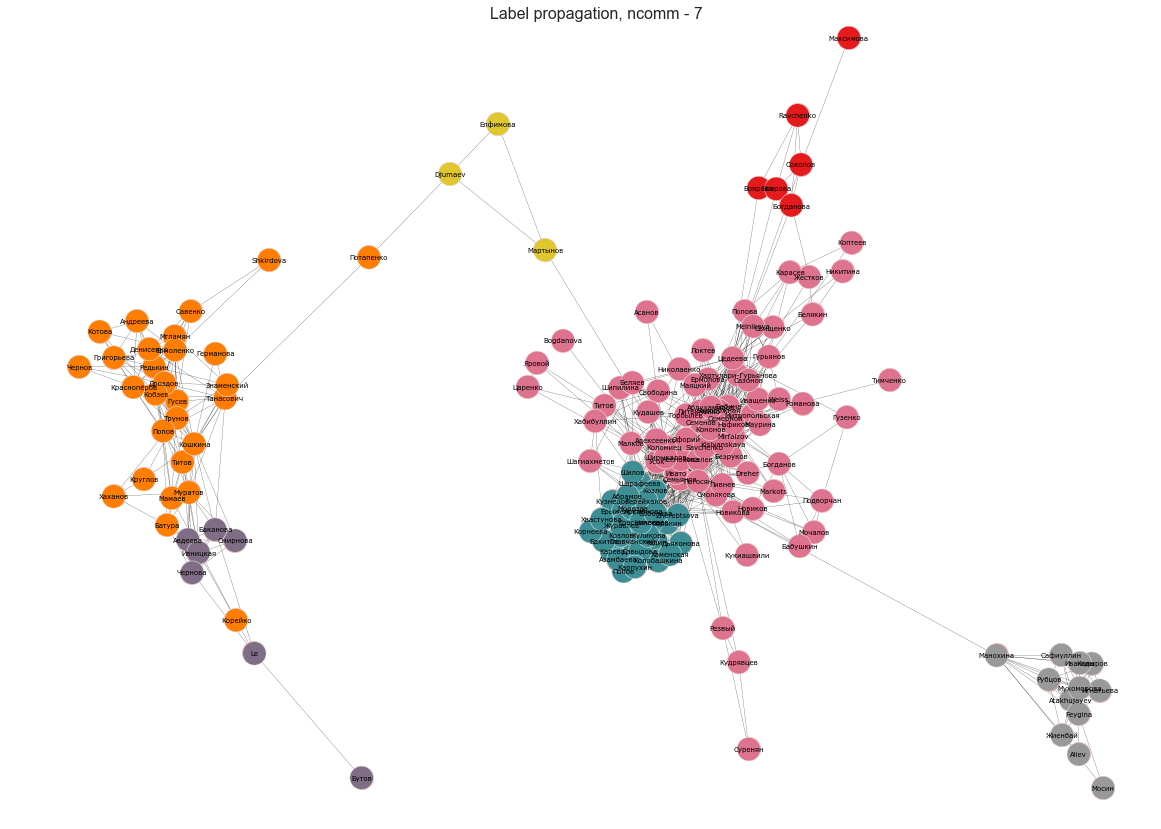

In [1423]:
plot_communities(colors_label_prop)
plt.title('Label propagation, ncomm - {}'.format(ncomm_label_prop), fontsize = 16)

This randomized algorithm is not bad, but nevertheless is slightly worse than walktrap algorithm in terms of interpretation!

Let's collect all the output in one dataframe:

In [1310]:
df_communities = pd.DataFrame(data = {'Modularity': [modular_louv, modular_spectr, 
                                                     modular_walktrap, modular_MCL,
                                                     modular_kcliq, modular_label_prop], 
                                     'Number of communities': [ncomm_louv, ncomm_spectr, 
                                                               ncomm_walktrap, ncomm_MCL,
                                                               ncomm_kcliq, ncomm_label_prop], 
                                     },
                             index = ['Louvain algorithm', 'Spectral modularity optm', 
                                      'Walktrap algorithm', 'Markov clustering',
                                      'K-clique percolation', 'Label propagation'])

In [1311]:
df_communities.round(decimals=2)

,Modularity,Number of communities
Louvain algorithm,0.51,8
Spectral modularity optm,0.48,9
Walktrap algorithm,0.46,10
Markov clustering,0.31,10
K-clique percolation,0.31,5
Label propagation,0.48,7


Finally, Walktrap algorithm is the best one in terms of interpretation. It also has high modularity value.